**Chapter 4 – Training Linear Models – Team 4 using Diamond dataset**

# Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os
import pandas as pd
import math 
import seaborn as sns
import collections

# Regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Saving plot under current directory/images/training_linear_models
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "training_linear_models"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# Use RMSE to analyse each model
def display_scores(scores):
    print('Cross Validation Result')
    print('RMSE:', scores)
    print('Mean: {:0.2f}'.format(scores.mean()))
    print('Standard deviation:{:0.2f}'.format(scores.std()))
    print(' ')
    
# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

# Extract Dataset

In [2]:
# reading the dataset
diamond = pd.read_csv("input/diamonds.csv", index_col=0)

In [3]:
## in case the table has any unseen structure
random_indices = np.random.permutation(diamond.shape[0])
diamond = diamond.iloc[random_indices]

In [4]:
diamond.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53940 entries, 1389 to 15796
Data columns (total 10 columns):
carat      53940 non-null float64
cut        53940 non-null object
color      53940 non-null object
clarity    53940 non-null object
depth      53940 non-null float64
table      53940 non-null float64
price      53940 non-null int64
x          53940 non-null float64
y          53940 non-null float64
z          53940 non-null float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.5+ MB


According to the info function the dataset has no null values. The dataset requires very less cleaning and we can directly start working on the dataset.

In [5]:
diamond.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
1389,0.24,Ideal,G,VVS1,62.1,56.0,559,3.97,4.00,2.47
50053,0.58,Very Good,F,VVS2,60.0,57.0,2201,5.44,5.42,3.26
41646,0.40,Ideal,E,VVS2,62.1,55.0,1238,4.76,4.74,2.95
42378,0.43,Premium,E,VVS2,60.8,57.0,1304,4.92,4.89,2.98
17245,1.55,Ideal,E,SI2,62.3,55.0,6901,7.44,7.37,4.61


In [6]:
diamond.describe().round(2)

,carat,depth,table,price,x,y,z
count,53940.00,53940.00,53940.00,53940.00,53940.00,53940.00,53940.00
mean,0.80,61.75,57.46,3932.80,5.73,5.73,3.54
std,0.47,1.43,2.23,3989.44,1.12,1.14,0.71
min,0.20,43.00,43.00,326.00,0.00,0.00,0.00
25%,0.40,61.00,56.00,950.00,4.71,4.72,2.91
50%,0.70,61.80,57.00,2401.00,5.70,5.71,3.53
75%,1.04,62.50,59.00,5324.25,6.54,6.54,4.04
max,5.01,79.00,95.00,18823.00,10.74,58.90,31.80


In [7]:
diamond.loc[(diamond['x']==0) | (diamond['y']==0) | (diamond['z']==0)].shape

(20, 10)

Only 20 observations with missing value, so just drop them

In [8]:
diamond = diamond.drop(diamond.loc[diamond.x <= 0].index)
diamond = diamond.drop(diamond.loc[diamond.y <= 0].index)
diamond = diamond.drop(diamond.loc[diamond.z <= 0].index)

diamond = diamond.drop(diamond.loc[diamond.y > 20].index)
diamond = diamond.drop(diamond.loc[diamond.z > 20].index)

According to describe function, Columns x (length), y (width), z (depth) have some zero values. 0 values for length, width or depth does not make sense hence we remove all such rows.

Besides, our dataset with maximum diamond price around USD 18,823, it is implausible for diamonds with x, y, z over 20 cm, so we also remove this kind of rows.

Total rows 53940->53917, deduct 23 rows.

In [9]:
diamond.shape

(53917, 10)

Saving figure Bar_cut


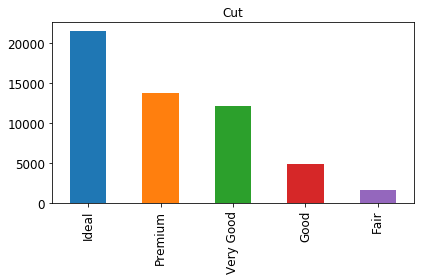

In [10]:
diamond['cut'].value_counts().plot(kind='bar')
plt.title("Cut")
save_fig("Bar_cut")

Saving figure Bar_color


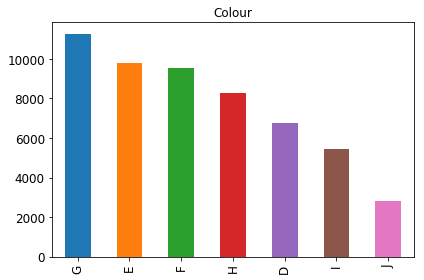

In [11]:
diamond['color'].value_counts().plot(kind='bar')
plt.title("Colour")
save_fig("Bar_color")

Saving figure Bar_clarity


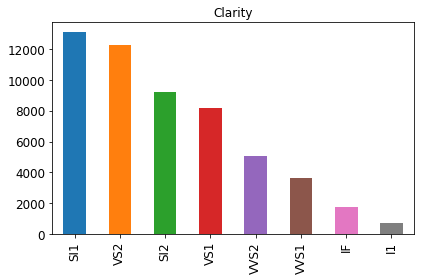

In [12]:
diamond['clarity'].value_counts().plot(kind='bar')
plt.title("Clarity")
save_fig("Bar_clarity")

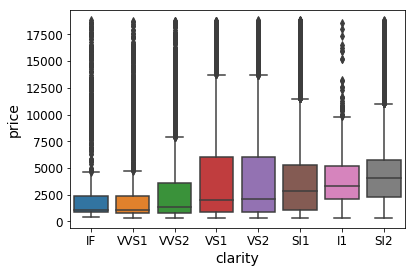

In [13]:
med = diamond.groupby('clarity')['price'].agg(np.median).sort_values()
sns.boxplot(diamond['clarity'],diamond['price'],order=med.index)

## One-hot Encoding

Feature Encoding is an important step before starting Regression. While different level of the feature of cut, color and clarity would affect the price of diamonds, their relationship between each level might not be linear. Instead of assigning then into numeric value, we decide to use one-hot encoding for these features.

In [14]:
diamond = pd.concat([diamond, pd.get_dummies(diamond['cut'], prefix='cut', drop_first=True)], axis=1)
diamond = pd.concat([diamond, pd.get_dummies(diamond['color'], prefix='color', drop_first=True)], axis=1)
diamond = pd.concat([diamond, pd.get_dummies(diamond['clarity'], prefix='clarity', drop_first=True)], axis=1)

In [15]:
diamond.drop(['cut','color','clarity'], axis=1, inplace= True)

In [16]:
diamond.shape

(53917, 24)

## Dimensions

Reduced Features by create Volume and it has a very High correlation with price more than x, y, z

In [17]:
diamond['volume'] = diamond['x']*diamond['y']*diamond['z']
diamond.head()

,carat,depth,table,price,x,y,z,cut_Good,cut_Ideal,cut_Premium,...,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2,volume
1389,0.24,62.1,56.0,559,3.97,4.00,2.47,0,1,0,...,0,0,0,0,0,0,0,1,0,39.223600
50053,0.58,60.0,57.0,2201,5.44,5.42,3.26,0,0,0,...,0,0,0,0,0,0,0,0,1,96.120448
41646,0.40,62.1,55.0,1238,4.76,4.74,2.95,0,1,0,...,0,0,0,0,0,0,0,0,1,66.559080
42378,0.43,60.8,57.0,1304,4.92,4.89,2.98,0,0,1,...,0,0,0,0,0,0,0,0,1,71.695224
17245,1.55,62.3,55.0,6901,7.44,7.37,4.61,0,1,0,...,0,0,0,0,1,0,0,0,0,252.779208


## Drop X, Y, Z

In [18]:
diamond.drop(['x','y','z'], axis=1, inplace= True)
diamond.head()

,carat,depth,table,price,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_E,color_F,...,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2,volume
1389,0.24,62.1,56.0,559,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,39.223600
50053,0.58,60.0,57.0,2201,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,1,96.120448
41646,0.40,62.1,55.0,1238,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,1,66.559080
42378,0.43,60.8,57.0,1304,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,71.695224
17245,1.55,62.3,55.0,6901,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,252.779208


# Test-Train Split before the closer data investigation

In [19]:
from sklearn.model_selection import train_test_split

#put several features in X
X = diamond.drop(['price'],1)
y = diamond['price']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=43)

## The test-train split should have been at the very beginning on this file, before you start 
### looking at the data. All the above investigations (i.e. correlations) should have been performed 
### on the train data only

print('Shape of train set X', X_train.shape)
print('Shape of train set y',y_train.shape)
print('Shape of test set X',X_test.shape)
print('Shape of test set y',y_test.shape)

Shape of train set X (43133, 21)
Shape of train set y (43133,)
Shape of test set X (10784, 21)
Shape of test set y (10784,)


In [20]:
diamond_train = X_train.copy();
diamond_train['price'] = y_train
del X
del diamond

## Seperate into numerical and categorical features

In [21]:
num_features = ['price','carat', 'depth', 'table', 'volume']
cat_features = ['cut', 'color', 'clarity']

In [22]:
diamond_train.describe()

,carat,depth,table,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_E,color_F,color_G,...,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2,volume,price
count,43133.000000,43133.000000,43133.000000,43133.000000,43133.000000,43133.000000,43133.000000,43133.000000,43133.000000,43133.000000,...,43133.000000,43133.000000,43133.000000,43133.000000,43133.000000,43133.000000,43133.000000,43133.000000,43133.000000,43133.000000
mean,0.797374,61.753384,57.458250,0.090441,0.401085,0.255442,0.223170,0.182111,0.176199,0.209584,...,0.052350,0.033269,0.241996,0.169824,0.151624,0.228039,0.067698,0.094104,129.760629,3932.338372
std,0.474010,1.428066,2.232072,0.286816,0.490124,0.436115,0.416376,0.385941,0.380994,0.407017,...,0.222734,0.179341,0.428297,0.375482,0.358660,0.419573,0.251229,0.291977,76.484210,3991.540971
min,0.200000,43.000000,44.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,31.707984,326.000000
25%,0.400000,61.000000,56.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,65.129092,945.000000
50%,0.700000,61.800000,57.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,114.886674,2401.000000
75%,1.040000,62.500000,59.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,170.760080,5340.000000
max,5.010000,79.000000,95.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,790.133208,18823.000000


# Visualization of Data

Lets visualize data to uncover hidden patterns if any in the dataset.

## Correlation Matrix

Plotting the correlation matrix to see what features are highly correlated.

Saving figure CM


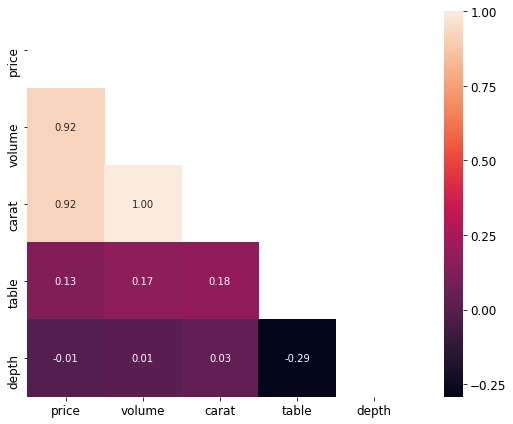

In [23]:
corrmat = diamond_train[num_features].corr()
f, ax = plt.subplots(figsize=(9, 6))
k = 5 #number of variables for heatmap
cols = corrmat.nlargest(k, 'price')['price'].index
cm = np.corrcoef(diamond_train[cols].values.T)

# Generate a mask for the upper triangle
mask = np.zeros_like(cm, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

hm = sns.heatmap(cm, vmax=1, mask=mask, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
save_fig("CM")
plt.show()

According to the correlation matrix price is highly correlated with the following features.

1. Carat of Diamond
2. Volume($X\times Y\times Z$) of Diamond

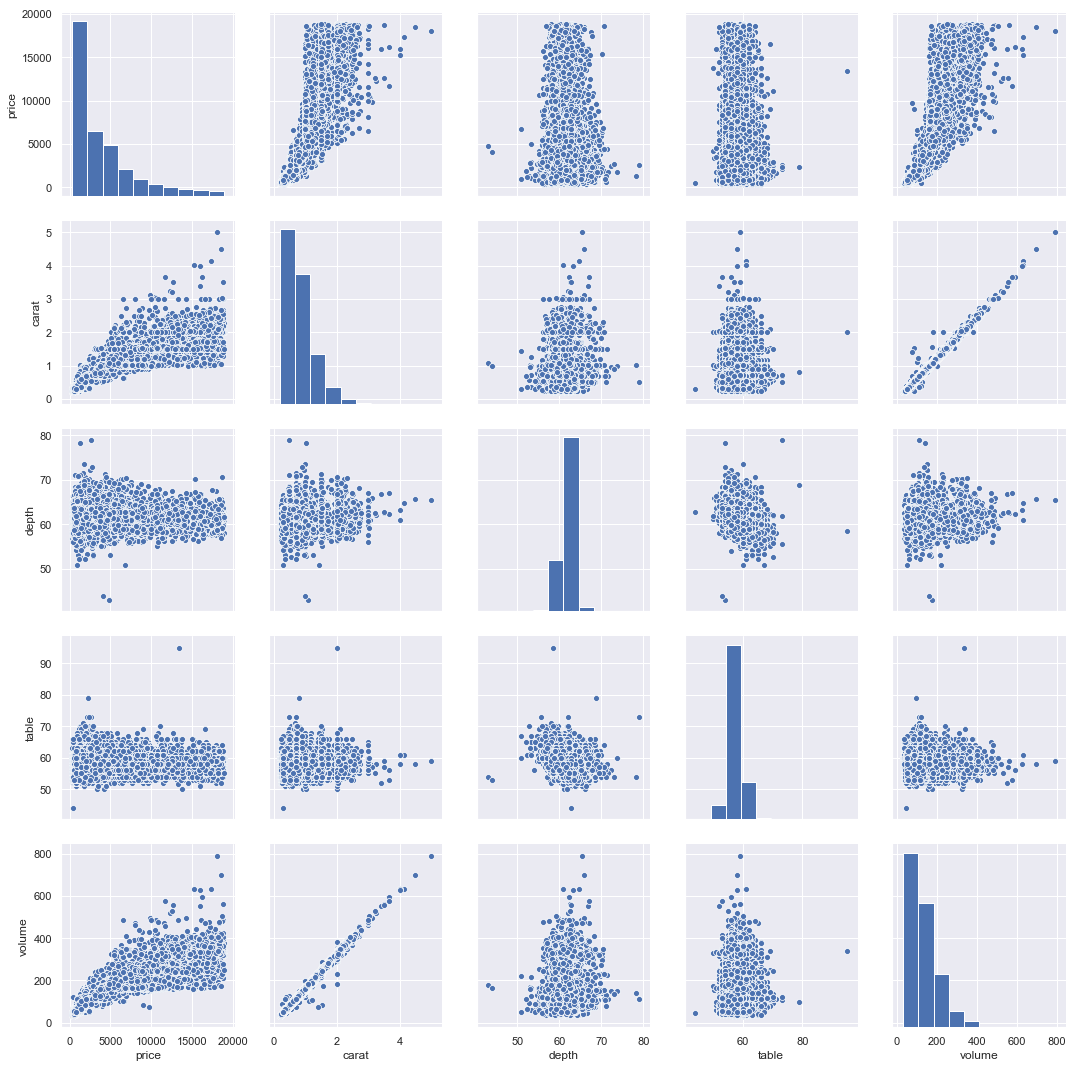

In [24]:
sns.set() #initialization for sns
cols = diamond_train.columns
sns.pairplot(diamond_train[num_features], height = 3)
plt.show();

## Price distribution

Saving figure Hist_price


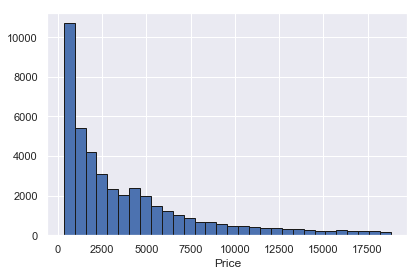

In [25]:
diamond_train['price'].hist(bins=30, edgecolor='k')
plt.xlabel("Price")
save_fig("Hist_price")

## Scatter plot for carat and price

Saving figure Scatterplot_carat_price


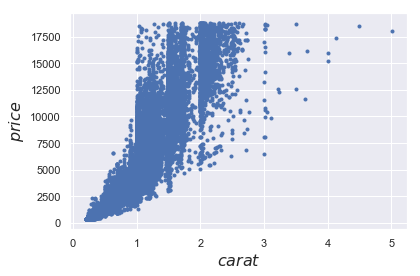

In [26]:
plt.plot(diamond_train['carat'], diamond_train['price'], "b.")
plt.xlabel("$carat$", fontsize=16)
plt.ylabel("$price$", rotation=90, fontsize=16)
save_fig("Scatterplot_carat_price")
plt.show()

# Scaling

In [27]:
num_features = ['carat', 'depth', 'table', 'volume']

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train[num_features])
X_train.loc[:, num_features] = scaler.transform(X_train[num_features])

In [28]:
X_train[num_features].describe().round(4)

,carat,depth,table,volume
count,43133.0000,43133.0000,43133.0000,43133.0000
mean,0.0000,0.0000,0.0000,0.0000
std,1.0000,1.0000,1.0000,1.0000
min,-1.2603,-13.1322,-6.0296,-1.2820
25%,-0.8383,-0.5276,-0.6533,-0.8450
50%,-0.2054,0.0326,-0.2053,-0.1945
75%,0.5119,0.5228,0.6907,0.5361
max,8.8873,12.0770,16.8194,8.6342


In [29]:
scaler.fit(X_test[num_features])
X_test.loc[:, num_features] = scaler.transform(X_test[num_features])

# Linear regression with Multiple variables

We'll use different regression models to predict the price of the diamond, then evaluate the model using cross validation and check RMSE of the scores to select the best model.

In [30]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

#coefficient
pd.Series(lin_reg.coef_,
          index=X_train.columns).sort_values(ascending=False).round(2)

clarity_IF       5489.60
clarity_VVS1     5114.68
clarity_VVS2     5024.40
clarity_VS1      4583.26
clarity_VS2      4276.70
clarity_SI1      3633.29
volume           2845.47
clarity_SI2      2690.33
carat            1360.88
cut_Ideal         868.34
cut_Premium       789.13
cut_Very Good     764.70
cut_Good          623.32
depth              26.52
table              -9.52
color_E          -225.85
color_F          -308.94
color_G          -514.67
color_H          -989.66
color_I         -1441.71
color_J         -2333.70
dtype: float64

In [31]:
from sklearn.metrics import mean_squared_error, r2_score
y_pred_train=lin_reg.predict(X_train)
print('Train Error {:0.2f}'.format(np.sqrt(mean_squared_error(y_train, y_pred_train))))
y_pred_test = lin_reg.predict(X_test)
print('Test Error {:0.2f}'.format(np.sqrt( mean_squared_error(y_test, y_pred_test))))

Train Error 1157.30
Test Error 1124.19


In [32]:
#evaluate a score by cross-validation
from sklearn.model_selection import cross_val_score, KFold

lin_scores = np.sqrt(-cross_val_score(lin_reg, X = X_train, y = y_train, scoring="neg_mean_squared_error", cv = 10))
display_scores(lin_scores)

Cross Validation Result
RMSE: [1160.05626223 1116.47231756 1193.46510254 1162.09505411 1138.54559853
 1213.53627892 1137.00735433 1188.99802739 1153.5492478  1117.66166877]
Mean: 1158.14
Standard deviation:30.85
 


In [33]:
import statsmodels.api as sm
from scipy import stats

X2 = sm.add_constant(X_train)
est = sm.OLS(y_train, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.916
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                 2.237e+04
Date:                Sat, 15 Jun 2019   Prob (F-statistic):               0.00
Time:                        13:17:26   Log-Likelihood:            -3.6546e+05
No. Observations:               43133   AIC:                         7.310e+05
Df Residuals:                   43111   BIC:                         7.311e+05
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -229.6379     58.578     -3.920

In [34]:
#try ridge/lasso for linear
lin_reg = Ridge(alpha=10)
lin_reg.fit(X_train, y_train)
y_pred_train=lin_reg.predict(X_train)
print('Train Error {:2f}'.format(np.sqrt(mean_squared_error(y_train, y_pred_train))))
y_pred_test = lin_reg.predict(X_test)
print('Test Error {:2f}'.format(np.sqrt( mean_squared_error(y_test, y_pred_test))))

Train Error 1158.708952
Test Error 1122.107110


Saving figure LR


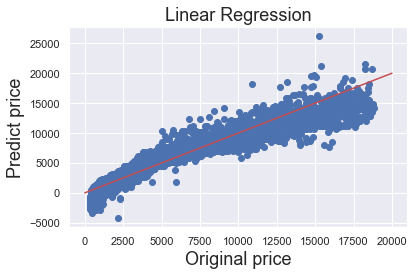

In [35]:
plt.scatter(y_test, y_pred_test)
plt.title("Linear Regression", fontsize=18)
plt.xlabel("Original price", fontsize=18)
plt.ylabel("Predict price", rotation=90, fontsize=18)
plt.plot([0,20000],[0, 20000],'r')
save_fig("LR")
plt.show()

# Try different degree of polynomial regression

In [36]:
from sklearn.preprocessing import PolynomialFeatures
# pass the order of your polynomial here  
poly_features = PolynomialFeatures(degree=1, include_bias=True)
# convert to be used further to linear regression

X_poly_train = poly_features.fit_transform(X_train)
X_poly_test = poly_features.transform(X_test)

poly_reg = LinearRegression()

In [37]:
from sklearn.preprocessing import PolynomialFeatures

for degree_ in range(1,4):
    # pass the order of your polynomial here  
    poly_features = PolynomialFeatures(degree=degree_, include_bias=True)
    # convert to be used further to linear regression
    X_poly_train = poly_features.fit_transform(X_train)
    X_poly_test = poly_features.transform(X_test)

    poly_reg.fit(X_poly_train, y_train)
    
    print('Degree: ', degree_)
    print('Nr of Features: ', X_poly_train.shape[1])
    
    y_pred_train = poly_reg.predict(X_poly_train)
    print('Train Error', np.sqrt(mean_squared_error(y_train, y_pred_train)))
    y_pred_test = poly_reg.predict(X_poly_test)
    print('Test Error', np.sqrt(mean_squared_error(y_test, y_pred_test)))
    print(' ')

Degree:  1
Nr of Features:  22
Train Error 1157.302752454886
Test Error 1124.1930424455404
 
Degree:  2
Nr of Features:  253
Train Error 761.9163517385257
Test Error 756.7298859732879
 
Degree:  3
Nr of Features:  2024
Train Error 595.3033118514585
Test Error 138655178.7628624
 


We can see when degree > 3, the number of errors decrease slowly and start to over-fitting, so we decide to choose polynomial regression with degree = 2 as our optimal model.

# Cross validation for polynomial regression in degree 2

In [38]:
from sklearn.preprocessing import PolynomialFeatures
# pass the order of your polynomial here  
poly_features = PolynomialFeatures(degree=2, include_bias=False)
# convert to be used further to linear regression

X_poly_train = poly_features.fit_transform(X_train)
X_poly_test = poly_features.transform(X_test)

In [39]:
poly_reg = LinearRegression()

poly_scores = cross_val_score(poly_reg, X = X_poly_train, y = y_train, scoring="neg_mean_squared_error", cv = 10)
poly_rmse_scores = np.sqrt(-poly_scores)

display_scores(poly_rmse_scores)

Cross Validation Result
RMSE: [784.41440902 745.33693157 825.65488782 787.36121666 723.54668003
 815.99758274 772.90839792 768.81526187 739.39144602 766.8082236 ]
Mean: 773.02
Standard deviation:30.58
 


Saving figure Poly


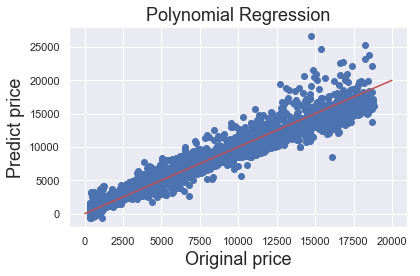

In [40]:
poly_reg = LinearRegression()

poly_features = PolynomialFeatures(degree=2, include_bias=True)
X_poly_train = poly_features.fit_transform(X_train)
X_poly_test = poly_features.transform(X_test)

poly_reg.fit(X_poly_train, y_train)
y_pred_train = poly_reg.predict(X_poly_train)
y_pred_test = poly_reg.predict(X_poly_test)


plt.scatter(y_test, y_pred_test)

plt.title("Polynomial Regression", fontsize=18)
plt.xlabel("Original price", fontsize=18)
plt.ylabel("Predict price", rotation=90 , fontsize=18)
plt.plot([0,20000],[0, 20000],'r')
save_fig("Poly")
plt.show()

# Ridge Regression

In [41]:
for degree_ in range(1,4):
    # pass the order of your polynomial here  
    poly_features = PolynomialFeatures(degree=degree_, include_bias=True)
    # convert to be used further to linear regression
    X_poly_train = poly_features.fit_transform(X_train)
    X_poly_test = poly_features.transform(X_test)

    ridge = Ridge(alpha=10)
    ridge.fit(X_poly_train, y_train)
    
    print('Degree: ', degree_)
    print('Nr of Features: ', X_poly_train.shape[1])
    
    y_pred_train = ridge.predict(X_poly_train)
    print('Train Error', np.sqrt( mean_squared_error(y_train, y_pred_train) ))
    y_pred_test = ridge.predict(X_poly_test)
    print('Test Error', np.sqrt( mean_squared_error(y_test, y_pred_test) ) )
    print(' ')

Degree:  1
Nr of Features:  22
Train Error 1158.7089522600772
Test Error 1122.107109873958
 
Degree:  2
Nr of Features:  253
Train Error 770.7208641472758
Test Error 757.9685835085742
 
Degree:  3
Nr of Features:  2024
Train Error 611.0617315451267
Test Error 630.8688515281849
 


In [42]:
from sklearn.preprocessing import PolynomialFeatures
# pass the order of your polynomial here  
poly_features = PolynomialFeatures(degree=3, include_bias=False)
# convert to be used further to linear regression

X_poly_train = poly_features.fit_transform(X_train)
X_poly_test = poly_features.transform(X_test)

In [43]:
ridge = Ridge(normalize=True)

ridge_scores = cross_val_score(ridge, X = X_poly_train, y = y_train, scoring="neg_mean_squared_error", cv = 10)
ridge_rmse_scores = np.sqrt(-ridge_scores)

display_scores(ridge_rmse_scores)

Cross Validation Result
RMSE: [ 951.85084814  863.09797398 1045.42748724  927.76937621  936.56443002
 1035.51890767  920.75419688  990.66211469 1019.88196526  907.9034168 ]
Mean: 959.94
Standard deviation:57.29
 


Saving figure Ridge


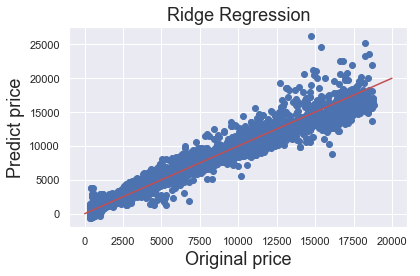

In [44]:
## try both and compare:
poly_reg = Ridge(alpha=10)

poly_features = PolynomialFeatures(degree=2, include_bias=True)
X_poly_train = poly_features.fit_transform(X_train)
X_poly_test = poly_features.fit_transform(X_test)

poly_reg.fit(X_poly_train, y_train)
y_pred_ridge_train = poly_reg.predict(X_poly_train)
y_pred_ridge_test = poly_reg.predict(X_poly_test)


plt.scatter(y_test, y_pred_ridge_test)
plt.title("Ridge Regression", fontsize=18)
plt.xlabel("Original price", fontsize=18)
plt.ylabel("Predict price", rotation=90, fontsize=18)
plt.plot([0,20000],[0, 20000],'r')
save_fig("Ridge")
plt.show()

# Lasso Regression

In [45]:
for degree_ in range(1,4):
    # pass the order of your polynomial here  
    poly_features = PolynomialFeatures(degree=degree_, include_bias=False)
    # convert to be used further to linear regression
    X_poly_train = poly_features.fit_transform(X_train)
    X_poly_test = poly_features.transform(X_test)

    lasso = Lasso(alpha=10)
    lasso.fit(X_poly_train, y_train)
    
    print('Degree: ', degree_)
    print('Nr of Features: ', X_poly_train.shape[1])
    
    y_pred_train = lasso.predict(X_poly_train)
    print('Train Error', np.sqrt( mean_squared_error(y_train, y_pred_train) ))
    y_pred_test = lasso.predict(X_poly_test)
    print('Test Error', np.sqrt( mean_squared_error(y_test, y_pred_test) ) )
    print(' ')

/Users/winnielin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 160436305.19297028, tolerance: 68719624.74964605
  positive)


Degree:  1
Nr of Features:  21
Train Error 1250.5098885208272
Test Error 1200.693841335521
 


/Users/winnielin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 110243310.86390686, tolerance: 68719624.74964605
  positive)


Degree:  2
Nr of Features:  252
Train Error 949.2347345909423
Test Error 903.2435317076109
 


/Users/winnielin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 803413944.8189278, tolerance: 68719624.74964605
  positive)


Degree:  3
Nr of Features:  2023
Train Error 880.7125680958409
Test Error 848.3798660294566
 


In [46]:
from sklearn.preprocessing import PolynomialFeatures
# pass the order of your polynomial here  
poly_features = PolynomialFeatures(degree=3, include_bias=False)
# convert to be used further to linear regression

X_poly_train = poly_features.fit_transform(X_train)
X_poly_test = poly_features.transform(X_test)

In [47]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=10)

lasso_scores = cross_val_score(lasso, X = X_poly_train, y = y_train, scoring = 'neg_mean_squared_error', cv = 10)
lasso_rmse_scores = np.sqrt(-lasso_scores)

display_scores(lasso_rmse_scores)

/Users/winnielin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 185181236.90885162, tolerance: 61958967.81596626
  positive)
/Users/winnielin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 194621870.3784523, tolerance: 61853561.12977242
  positive)
/Users/winnielin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1113651340.2537308, tolerance: 61615315.846480034
  positive)
/Users/winnielin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want 

Cross Validation Result
RMSE: [898.41801935 858.19160286 975.52719027 999.82043852 845.73907453
 953.61351147 854.45520403 874.69538094 896.28684096 847.03785394]
Mean: 900.38
Standard deviation:53.64
 


/Users/winnielin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1567242531.2260895, tolerance: 61639890.945748806
  positive)


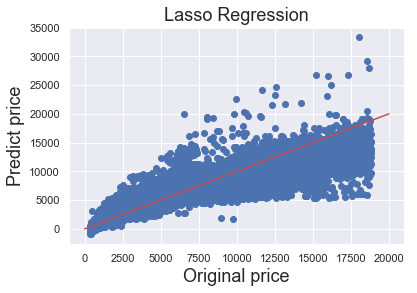

In [48]:
## try both and compare:
poly_reg = Lasso(normalize=True)

poly_features = PolynomialFeatures(degree=3, include_bias=True)
X_poly_train = poly_features.fit_transform(X_train)

poly_reg.fit(X_poly_train, y_train)
y_pred_ridge_train = poly_reg.predict(X_poly_train)

plt.scatter(y_train, y_pred_ridge_train)
plt.title("Lasso Regression", fontsize=18)
plt.xlabel("Original price", fontsize=18)
plt.ylabel("Predict price", rotation=90, fontsize=18)
plt.plot([0,20000],[0, 20000],'r')
plt.show()

# KNN

In [49]:
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=7)
knn.fit(X_train, y_train)
y_pred_train = knn.predict(X_train)
print('Train Error', np.sqrt( mean_squared_error(y_train, y_pred_train)))
y_pred_test = knn.predict(X_test)
print('Test Error', np.sqrt( mean_squared_error(y_test, y_pred_test)))

Train Error 733.6700819168482
Test Error 850.9526955193558


Saving figure kNN


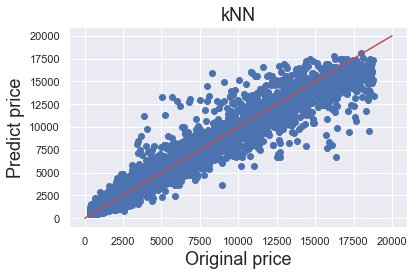

In [50]:
plt.scatter(y_test, y_pred_test)
plt.title("kNN", fontsize=18)
plt.xlabel("Original price", fontsize=18)
plt.ylabel("Predict price", rotation=90, fontsize=18)
plt.plot([0,20000],[0, 20000],'r')
save_fig("kNN")
plt.show()

In [51]:
from sklearn.neighbors import KNeighborsRegressor

candidates = np.arange(4,11)
rmse_metrics = []
for k in candidates:
    model = KNeighborsRegressor(n_neighbors=k, weights='distance', metric='minkowski', leaf_size=50, n_jobs=4)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    metric = np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred))
    rmse_metrics.append(metric)

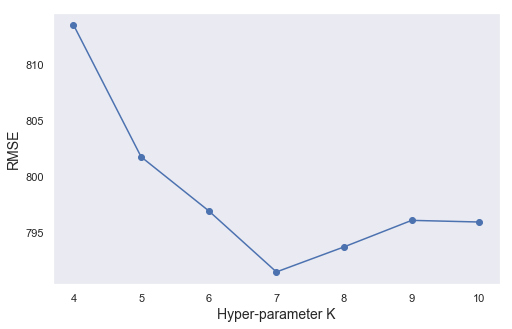

In [52]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(candidates, rmse_metrics, "o-")
ax.set_xlabel('Hyper-parameter K', fontsize=14)
ax.set_ylabel('RMSE', fontsize=14)
ax.set_xticks(candidates)
ax.grid();

In [53]:
knn = KNeighborsRegressor(n_neighbors=7)
knn_scores = cross_val_score(knn, X = X_train, y = y_train, scoring="neg_mean_squared_error", cv = 10)
knn_rmse_scores = np.sqrt(-knn_scores)

display_scores(knn_rmse_scores)

Cross Validation Result
RMSE: [882.79674808 834.23527186 936.90622963 922.06515996 848.99864452
 895.74261098 880.91685688 849.14922322 855.18800815 872.56032782]
Mean: 877.86
Standard deviation:31.46
 


# Random Forest

In [54]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 10)
rf.fit(X_train, y_train)
y_pred_train = rf.predict(X_train)
print('Train Error {:0.2f}'.format(np.sqrt(mean_squared_error(y_train, y_pred_train))))
y_pred_test = rf.predict(X_test)
print('Test Error {:0.2f}'.format(np.sqrt(mean_squared_error(y_test, y_pred_test))))

Train Error 274.56
Test Error 649.80


In [55]:
rf = RandomForestRegressor(n_estimators = 10)
rf_scores = cross_val_score(rf, X = X_train, y = y_train, scoring="neg_mean_squared_error", cv = 10)
rf_rmse_scores = np.sqrt(-rf_scores)

display_scores(rf_rmse_scores)

Cross Validation Result
RMSE: [646.06150339 640.13002315 694.0133526  686.6762023  619.65739879
 682.25343083 687.10192787 632.12928265 599.19954367 642.12073344]
Mean: 652.93
Standard deviation:31.00
 


In [56]:
demo_pred = X_test.iloc[:10].copy()
pred_dict = {'y_true':y_test[:10]}
pred_dict['pred_RF'] = y_pred_test[:10].round(1)
pred_dict['diff'] = pred_dict['y_true'] - pred_dict['pred_RF']
pd.DataFrame(pred_dict)

,y_true,pred_RF,diff
41676,1240,1115.5,124.5
39354,1073,1040.4,32.6
33807,842,972.9,-130.9
40714,1160,1282.8,-122.8
44372,1580,1554.3,25.7
6479,4056,3499.5,556.5
5071,3750,3872.6,-122.6
4605,3660,3655.3,4.7
14913,6002,9238.2,-3236.2
39103,1061,919.4,141.6


Saving figure RF


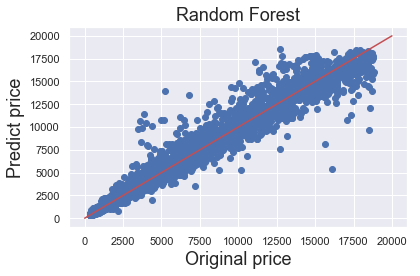

In [57]:
plt.scatter(y_test, y_pred_test)
plt.title("Random Forest", fontsize=18)
plt.xlabel("Original price", fontsize=18)
plt.ylabel("Predict price", rotation=90, fontsize=18)
plt.plot([0,20000],[0, 20000],'r')
save_fig("RF")
plt.show()

# ANN

In [58]:
from keras.models import Sequential
nn_reg = Sequential()

Using TensorFlow backend.


In [59]:
from keras.layers import Dense

In [60]:
n_input = X_train.shape[1]
n_hidden1 = 32
# first hidden layer
nn_reg.add(Dense(units=n_hidden1, activation='relu', input_shape=(n_input,)))
n_hidden2 = 16
n_hidden3 = 8
# add second hidden layer
nn_reg.add(Dense(units=n_hidden2, activation='relu'))
# add third hidden layer
nn_reg.add(Dense(units=n_hidden3, activation='relu'))

Instructions for updating:
Colocations handled automatically by placer.


In [61]:
# output layer
nn_reg.add(Dense(units=1, activation=None))

In [62]:
## compiling step
nn_reg.compile(loss='mean_squared_error', optimizer='adam')

In [63]:
nn_reg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                704       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 1,377
Trainable params: 1,377
Non-trainable params: 0
_________________________________________________________________


In [64]:
batch_size = 64
n_epochs = 50
nn_reg.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
43133/43133 [==============================] - 4s 102us/step - loss: 16303899.0385
Epoch 2/50
43133/43133 [==============================] - 2s 37us/step - loss: 1757647.2968
Epoch 3/50
43133/43133 [==============================] - 2s 35us/step - loss: 1311970.0343
Epoch 4/50
43133/43133 [==============================] - 2s 42us/step - loss: 1139137.9441
Epoch 5/50
43133/43133 [==============================] - 2s 56us/step - loss: 1002047.0416
Epoch 6/50
43133/43133 [==============================] - 2s 42us/step - loss: 895230.5977
Epoch 7/50
43133/43133 [==============================] - 3s 60us/step - loss: 829141.7321
Epoch 8/50
43133/43133 [==============================] - 2s 38us/step - loss: 782522.6768
Epoch 9/50
43133/43133 [==============================] - 2s 43us/step - loss: 743750.0011
Epoch 10/50
43133/43133 [==============================] - 2s 49us/step - loss: 712854.8002
Epoch 11/50
43133/43133 [=========

In [65]:
from sklearn.metrics import mean_squared_error
y_pred_train = nn_reg.predict(X_train)
print('Train Error {:0.2f}'.format(np.sqrt(mean_squared_error(y_train, y_pred_train))))
y_pred_test = nn_reg.predict(X_test)
print('Test Error {:0.2f}'.format(np.sqrt(mean_squared_error(y_test, y_pred_test))))

Train Error 602.73
Test Error 595.20


Saving figure ANN


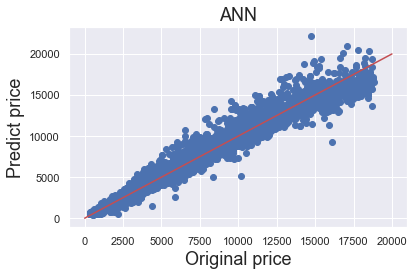

In [66]:
plt.scatter(y_test, y_pred_test)
plt.title("ANN", fontsize=18)
plt.xlabel("Original price", fontsize=18)
plt.ylabel("Predict price", rotation=90, fontsize=18)
plt.plot([0,20000],[0, 20000],'r')
save_fig("ANN")

plt.show()

In [67]:
y_pred_test = y_pred_test.flatten()
residuals = y_test - y_pred_test
proper_error = residuals.abs()/y_test
metric = 100*(proper_error<0.15).mean()
print("Prediction error < 15%: {:.2f}%".format(metric))

Prediction error < 15%: 79.66%


Saving figure ANN_residuals


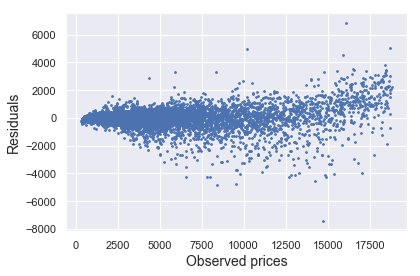

In [68]:
y_pred_test = y_pred_test.flatten()
residuals = y_test - y_pred_test
plt.scatter(y_test, residuals, s=3)
plt.xlabel("Observed prices", fontsize=14)
plt.ylabel("Residuals", rotation=90, fontsize=14)
save_fig("ANN_residuals")

plt.show()

Saving figure ANN_percent


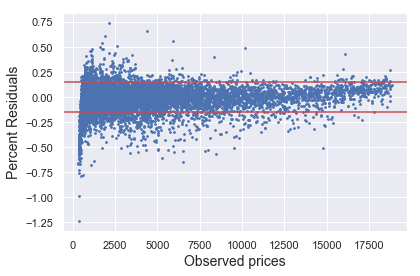

In [69]:
y_pred_test = y_pred_test.flatten()
percent_residuals = (y_test - y_pred_test)/y_test
plt.scatter(y_test, percent_residuals, s=3)
plt.xlabel("Observed prices", fontsize=14)
plt.ylabel("Percent Residuals", rotation=90, fontsize=14)
plt.axhline(y=0.15, color='r');
plt.axhline(y=-0.15, color='r');
save_fig("ANN_percent")

plt.show()

In [70]:
demo_pred = X_test.iloc[:10].copy()
pred_dict = {'y_true':y_test[:10]}
pred_dict['pred_NN'] = y_pred_test[:10].flatten().round(1)
pd.DataFrame(pred_dict)

,y_true,pred_NN
41676,1240,987.700012
39354,1073,1281.300049
33807,842,803.900024
40714,1160,1221.300049
44372,1580,1531.000000
6479,4056,3221.600098
5071,3750,3969.500000
4605,3660,3701.699951
14913,6002,6564.000000
39103,1061,936.799988


# RMSE table

In [71]:
rmse = pd.DataFrame(columns=['train', 'test'], index=['LR','Poly', 'Ridge', 'Lasso','kNN','RF','ANN'])

rmse.loc['LR','train'] = np.sqrt(mean_squared_error(y_true=y_train, y_pred=lin_reg.predict(X_train)))
rmse.loc['LR','test'] = np.sqrt(mean_squared_error(y_true=y_test, y_pred=lin_reg.predict(X_test)))

knn = KNeighborsRegressor(n_neighbors=7)
knn.fit(X_train, y_train)
rmse.loc['kNN','train'] = np.sqrt(mean_squared_error(y_true=y_train, y_pred=knn.predict(X_train)))
rmse.loc['kNN','test'] = np.sqrt(mean_squared_error(y_true=y_test, y_pred=knn.predict(X_test)))

rf = RandomForestRegressor(n_estimators = 10)
rf.fit(X_train, y_train)
rmse.loc['RF','train'] = np.sqrt(mean_squared_error(y_true=y_train, y_pred=rf.predict(X_train)))
rmse.loc['RF','test'] = np.sqrt(mean_squared_error(y_true=y_test, y_pred=rf.predict(X_test)))

rmse.loc['ANN','train'] = np.sqrt(mean_squared_error(y_true=y_train, y_pred=nn_reg.predict(X_train)))
rmse.loc['ANN','test'] = np.sqrt(mean_squared_error(y_true=y_test, y_pred=nn_reg.predict(X_test)))


poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly_train = poly_features.fit_transform(X_train)
X_poly_test = poly_features.transform(X_test)
poly_reg.fit(X_poly_train, y_train)

rmse.loc['Poly','train'] = np.sqrt(mean_squared_error(y_true=y_train, y_pred=poly_reg.predict(X_poly_train)))
rmse.loc['Poly','test'] = np.sqrt(mean_squared_error(y_true=y_test, y_pred=poly_reg.predict(X_poly_test)))

ridge = Ridge(alpha=10)
ridge.fit(X_poly_train, y_train)

rmse.loc['Ridge','train'] = np.sqrt(mean_squared_error(y_true=y_train, y_pred=ridge.predict(X_poly_train)))
rmse.loc['Ridge','test'] = np.sqrt(mean_squared_error(y_true=y_test, y_pred=ridge.predict(X_poly_test)))

lasso = Lasso(alpha=10)
lasso.fit(X_poly_train, y_train)

rmse.loc['Lasso','train'] = np.sqrt(mean_squared_error(y_true=y_train, y_pred=lasso.predict(X_poly_train)))
rmse.loc['Lasso','test'] = np.sqrt(mean_squared_error(y_true=y_test, y_pred=lasso.predict(X_poly_test)))


rmse

/Users/winnielin/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 110243310.86390686, tolerance: 68719624.74964605
  positive)


,train,test
LR,1158.71,1122.11
Poly,1446.7,1404.49
Ridge,770.721,757.969
Lasso,949.235,903.244
kNN,733.67,850.953
RF,273.489,660.383
ANN,602.732,595.199
